# IFU of YSOs in LMC

**Use case:** Automatically detect point sources and extract photometry in a 3D cube. Analyze spectral lines.<br>
**Data:** ALMA 13CO data cubes.<br>
**Tools:** specutils, photutils, astropy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

The LMC is the ideal site to study massive star formation because it is relatively close (d ~ 50 kpc) and has a face-on orientation so that we can resolve individual star formation sites and eliminate line of sight confusion. The Spitzer and Herschel surveys have identified thousands of YSOs in the LMC by using photometry that spans from 3 microns to 500 microns and are complete down to 8 solar mass YSOs. 

 We know massive star formation occurs in dense molecular gas. ALMA observations of 12CO and 13CO molecular gas show evidence that colliding filaments can be a mechanisms for gas densities to be as high as 10^6 cm^-3. Massive stars up go 50 solar masses have been observed in dense cores at the center of colliding CO gas filaments seen with ALMA.

The instruments on JWST will have angular resolutions 10 times better than Spitzer Space Telescope and sensitivities over a hundred times better than current instruments. Observations of YSOs with MIRI and NIRCam will be complete down to 1 solar mass YSOs, as oppose to 8 solar mass YSOs with Spitzer observations. The massive YSOs in the LMC are most likely a small cluster of YSOs, and with MRS we can get spectra of the individual object in the cluster. This will be a powerful tool in understanding star formation and cluster formation.

For the first part, I use ALMA 13CO data cubes to read in the cube and make figures. There are nearly 400 massive stars in the footprint shown in this notebook. One of the goals of this notebook is to use photutils to automatically detect point sources and extract photometry in a given 3D cube. For the second part, I use Spitzer/IRS spectra of a known early-stage YSOs. YSOs have specific absorption and emission lines. The goal is to first use specutils to find the important lines to first identify if something is or is not a YSO based on what lines do exist or do not exist. And then the next step is to identify if the YSO is Stage I (most embedded with CO2 ice feature), Stage II (more evolved with ice and silicate absorption features), or Stage III (almost a flat spectrum with PAH emission) based on the emission and absorption lines detected.

### Import things you need

In [1]:
import os

from astropy import units as u
from astropy.wcs import WCS
from astropy import constants as const
from astropy.io import ascii, fits
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clipped_stats
from astropy.utils.data import download_file
import urllib.request

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from spectral_cube import SpectralCube
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr, line_flux, centroid, equivalent_width
from specutils.fitting import fit_generic_continuum, fit_continuum, find_lines_threshold,  find_lines_derivative, estimate_line_parameters, fit_lines
from specutils.manipulation import noise_region_uncertainty, box_smooth, extract_region, gaussian_smooth, SplineInterpolatedResampler

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Check versions of imported things

In [3]:
import aplpy
from aplpy import __version__ as aplpy_version
print("Aplpy: {}".format(aplpy_version))

import astrodendro
from astrodendro import __version__ as astrodendro_version
print("Astrodendro: {}".format(astrodendro_version))

import astropy
from astropy import __version__ as astropy_version
print("Astropy: {}".format(astropy_version))

import jwst
from jwst import __version__ as jwst_version
print("JWST: {}".format(jwst_version))

import matplotlib
from matplotlib import __version__ as matplotlib_version
print("Matplotlib: {}".format(matplotlib_version))

import numpy
from numpy import __version__ as numpy_version
print("Numpy: {}".format(numpy_version))

import pandas
from pandas import __version__ as pandas_version
print("Pandas: {}".format(pandas_version))

import photutils
from photutils import __version__ as photutils_version
print("Photutils: {}".format(photutils_version))

import scipy
from scipy import __version__ as scipy_version
print("Scipy: {}".format(scipy_version))

import specutils
from specutils import __version__ as specutils_version
print("Specutils: {}".format(specutils_version))

import spectral_cube
from spectral_cube import __version__ as spectral_cube_version
print("SpectralCube: {}".format(spectral_cube_version))

Aplpy: 2.1.0
Astrodendro: 0.2.1.dev42+g3181c36
Astropy: 5.3.4
JWST: 1.12.5
Matplotlib: 3.8.0
Numpy: 1.25.2
Pandas: 2.1.2
Photutils: 1.9.0
Scipy: 1.9.3
Specutils: 1.12.0
SpectralCube: 0.6.3


### Setup output directory for figures and spectra

The user needs to setup their own path to where they want the output to be located.

In [4]:
output_images = './Images' # This is where the output images will be located
output_spectra = './Spectra' # This is where the output spectra will be located

for directory in [output_images, output_spectra]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Set plot paramters

In [5]:
params = {'legend.fontsize': '18',
        'axes.labelsize': '18',
        'axes.titlesize': '18',
        'xtick.labelsize': '18',
        'ytick.labelsize': '18',
        'lines.linewidth': 2,
        'axes.linewidth': 2,
        'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

### Set path to data

Using ALMA 13CO from a known star formation region in the LMC host to nearly 150 massive YSOs.

#### Note that the data file is ~2 GB, so download will take a while depending on your internet speed. You can also download directly using the link below.

In [6]:
data_file = './LMC_13CO.fits'
if os.path.exists("LMC_13CO.fits"):
    print("LMC_13CO.fits Already Exists")
else:
    print("Downloading LMC_13CO.fits")
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_IFU_YSOs_in_the_LMC/LMC_13CO.fits'
    urllib.request.urlretrieve(url, './LMC_13CO.fits')

### Load and display data cube

In [7]:
cube = SpectralCube.read(data_file, hdu=1)  
print(cube)

SpectralCube with shape=(784, 784, 810) and unit=K:
 n_x:    810  type_x: RA---SIN  unit_x: deg    range:    84.678990 deg:   84.836488 deg
 n_y:    784  type_y: DEC--SIN  unit_y: deg    range:   -69.101848 deg:  -69.047473 deg
 n_s:    784  type_s: VRAD      unit_s: m / s  range:   220018.197 m / s:  285027.957 m / s


### Trim the cube

Not sure about JWST MRS cube, but in ALMA the beginning and end of cube have poor data quality so you can trim the cube to make it smaller if you want. I used the whole cube in this example.

If you want to trim the cube to a certain spectral range then do the following:

```
subcube = cube.spectral_slab(240 * (u.m/u.s), 265 * (u.m/u.s))
cube = subcube
```

In [8]:
cube.allow_huge_operations = True
cmin = cube.minimal_subcube()

### Make a 2D image from the 3D cube either with average, median, or sum

This is to look for point sources. After you locate point sources, you will be applying aperture photometry to extract the spectrum.

**The code can take awhile** since it is a big data cube.

In [9]:
cont_img = cmin.sum(axis=0)

### Plot the image to do a visual check

This is to see if you even see any emission and to make sure you have the correct data cube.

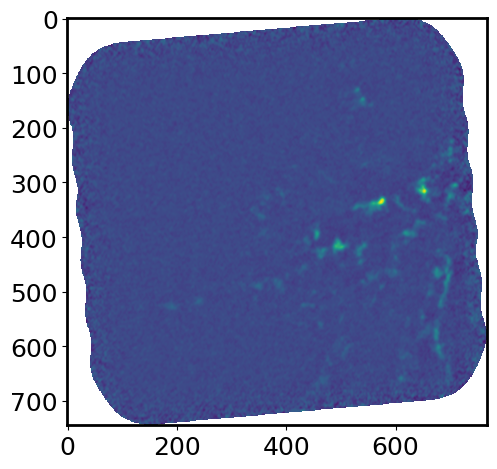

In [10]:
fig = plt.figure()
plt.imshow(cont_img.value)
plt.tight_layout()
plt.show()

### Plot the summed image with WCS coordinates and save the figure

INFO: Auto-setting vmin to -2.060e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.214e+02 [aplpy.core]


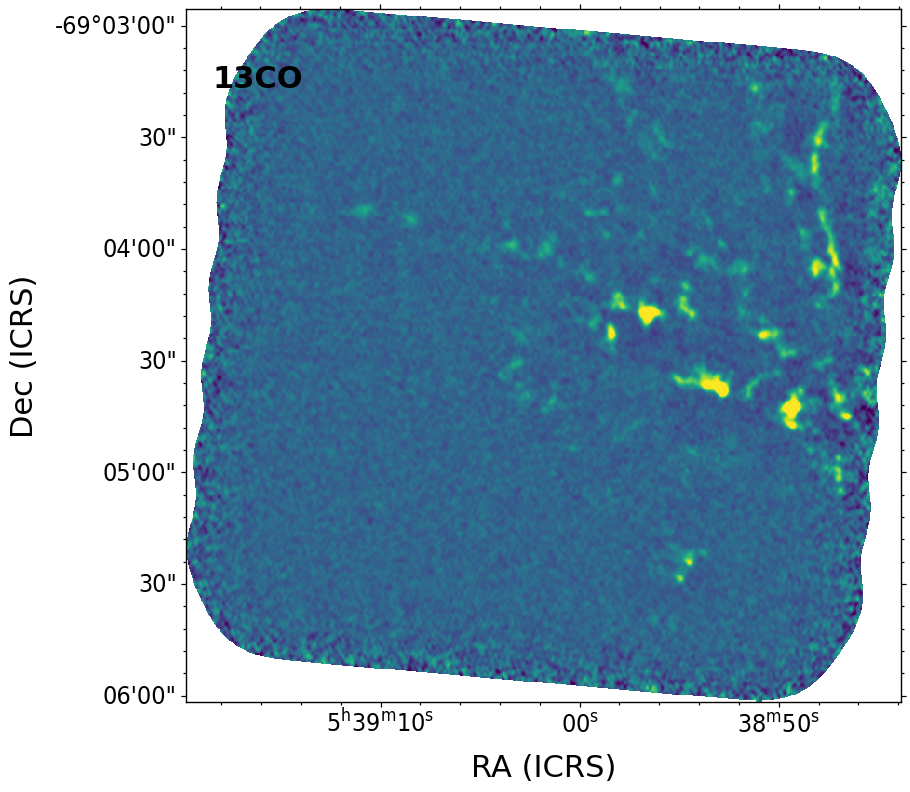

In [11]:
name = '13CO'

F = aplpy.FITSFigure(cont_img.hdu, north=True)
F.show_colorscale()
F.add_label(0.1, 0.9, name, relative=True, size=22, weight='bold')
F.axis_labels.set_font(size=22)
F.tick_labels.set_font(size=18, stretch='condensed')
F.save(output_images+"_"+name+".pdf", dpi=300) 

### Identify all point sources using photutils

In [12]:
# Empty array to store values
name_val = []
source_val = []
ra_val = []
dec_val = []

# Find mean, meadian, and standard deviation of the summed image
mean, median, std = sigma_clipped_stats(cont_img.value, sigma=2.0)

### Get a list of all point sources

Note that usually it is `3*std` to find sources above noise level, but there are 247 point sources when I do that. So I made it `6*std` to look at 4 point sources and make sure this step works.

In [13]:
daofind = DAOStarFinder(fwhm=2.0, threshold=6*std)
sources = daofind(cont_img.value - median) 
print("\n  Number of sources in field: ", len(sources))


  Number of sources in field:  3


### Extract and plot spectrum of all sources

**This step can take while to run.**

Do a visual check to see if all point sources have been identified, although the end result should be that this is not necessary. Also as a science user, I would like the algorithm to tell me what is and isn't a point source mathematically. There should be some criteria that differences point and extended sources that the user shouldn't have to visually check. Of the four sources, two are noise spectra because it detected noise spikes on the border of the ALMA cube which is a common thing with ALMA data cubes.

 id xcentroid ycentroid sharpness  ... sky    peak      flux        mag     
--- --------- --------- ---------- ... --- --------- --------- -------------
  1 653.09409 317.15729 0.50840302 ...   0  1221.437  1.249911   -0.24219768
  2 766.30069 580.17569 0.42484061 ...   0 182.39641 1.0799998  -0.083559192
  3 686.12788 691.54337  0.5235201 ...   0 298.29745 1.0037725 -0.0040882302
05h38m49.22767599s -69d04m42.40069582s


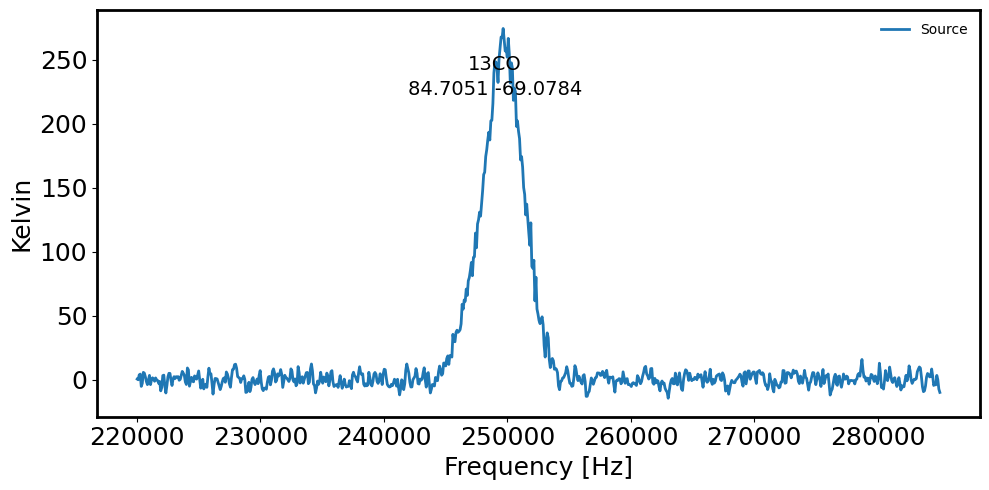

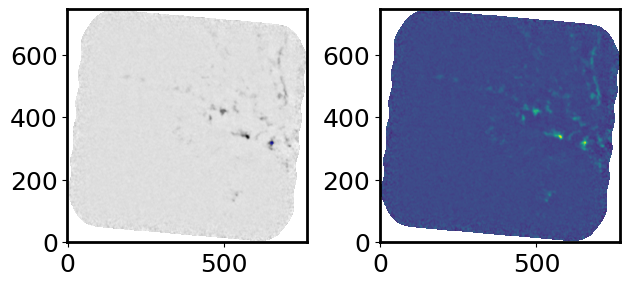

05h38m43.95881933s -69d03m36.6168287s


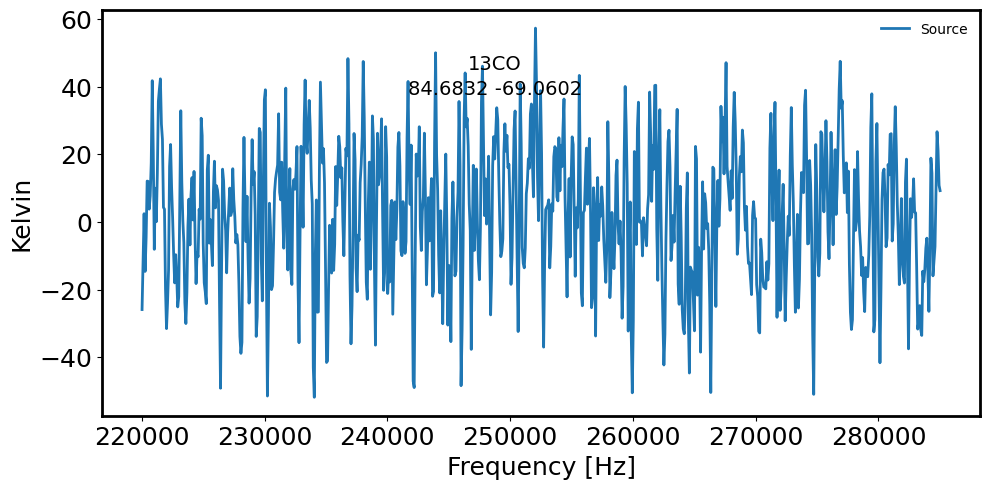

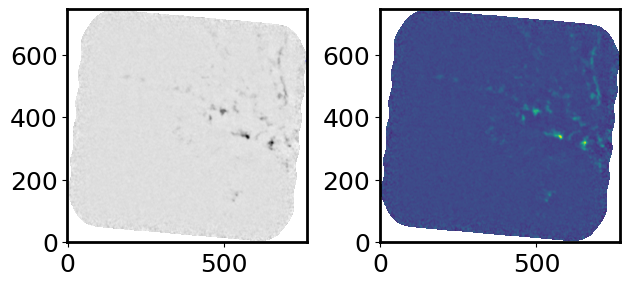

05h38m47.70264094s -69d03m08.79671287s


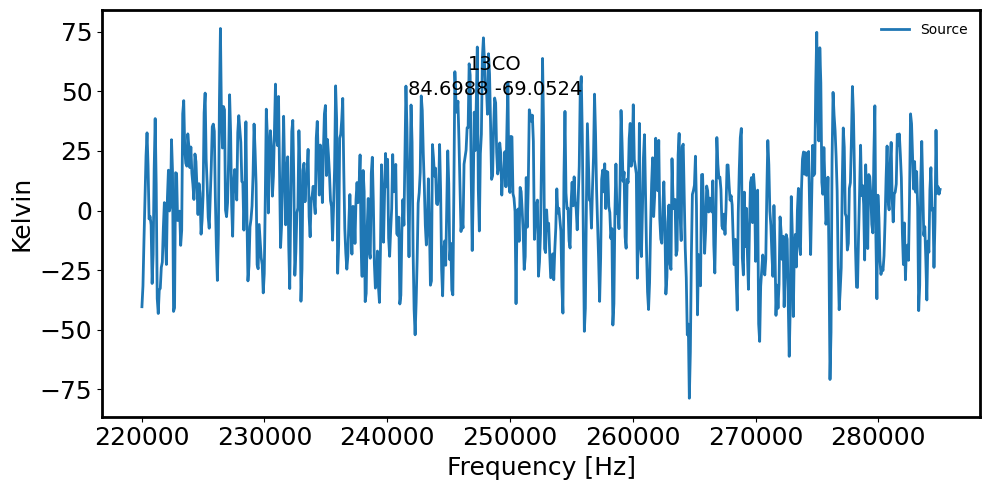

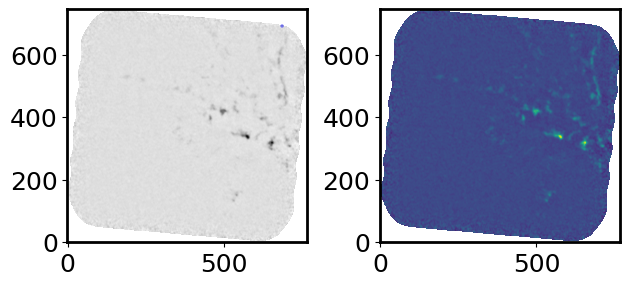

In [14]:
# Make table be consistent with RA and DEC coordinates
if len(sources) > 0:
    for col in sources.colnames:    
        sources[col].info.format = '%.8g'

    print(sources)  
    
    # Convert xcentroid and ycentroid to RA and DEC coordiantes
    positions = Table([sources['xcentroid'], sources['ycentroid']])                
    w = WCS(cont_img.header)                                                       
    radec_lst = w.pixel_to_world(sources['xcentroid'], sources['ycentroid'])

    # Aperture extract spectrum of point source Using a cirular aperture            
    for countS, _ in enumerate(sources):
        print(radec_lst[countS].to_string('hmsdms'))  # Print the RA and Dec in hms dms values   
        
        name_val.append(name)
        source_val.append(countS)
        ra_val.append(radec_lst[countS].ra.deg)
        dec_val.append(radec_lst[countS].dec.deg)
    
        # Size of frame 
        ysize_pix = cmin.shape[1]
        xsize_pix = cmin.shape[2]

        # Set up some centroid pixel for the source 
        ycent_pix = sources['ycentroid'][countS]
        xcent_pix = sources['xcentroid'][countS]

        # Make an aperture radius for source
        # This can be something the user inputs based on their own science expertise.
        apertureRad_pix = 2

        # Make a masked array for the apeture
        yy, xx = np.indices([ysize_pix, xsize_pix], dtype='float')  # Check ycentpix, xcentpix are in correct order 
        radius = ((yy - ycent_pix)**2 + (xx - xcent_pix)**2)**0.5  # Make a circle in the frame

        mask = radius <= apertureRad_pix  # Select pixels within the aperture radius
        maskedcube = cmin.with_mask(mask)  # Make a masked cube
        pixInAp = np.count_nonzero(mask == 1)  # Pixels in apeture

        spectrum = maskedcube.sum(axis=(1, 2))  # Extract the spectrum from only the annulus
        noisespectrum = maskedcube.std(axis=(1, 2))  # Extract the noise spectrum for the source 

        # Measure a spectrum from the background. Use an annulus arround the source.
        an_mask = (radius > apertureRad_pix + 1) & (radius <= apertureRad_pix + 2)  # Select pixels within an anulus
        an_maskedcube = cmin.with_mask(an_mask)  # Make a masked cube
    
        # Plot the spectrum extracted from cirular aperture via: a sum extraction 
        
        fig = plt.figure(figsize=(10, 5))
        
        plt.plot(maskedcube.spectral_axis.value, spectrum.value, label='Source')  # Source spectrum 
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Kelvin') 
        plt.gcf().text(0.5, 0.85, name, fontsize=14, ha='center')
        plt.gcf().text(0.5, 0.80, radec_lst[countS].to_string('decimal'), ha='center', fontsize=14)
        plt.legend(frameon=False, fontsize='medium')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        positions_pix = (sources['xcentroid'], sources['ycentroid'])
    
        apertures = CircularAperture([positions_pix[0][countS], positions_pix[1][countS]], r=2.)
        fig = plt.figure()            

        plt.subplot(1, 2, 1)
        plt.imshow(cont_img.value, cmap='Greys', origin='lower')
        
        apertures.plot(color='blue', lw=1.5, alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.imshow(cont_img.value, origin='lower')
        plt.tight_layout()
        plt.show()
        plt.close()
    

### Make a Table for the Extracted Sources

In [15]:
sourceExtSpecTab = Table([name_val, source_val, ra_val, dec_val], 
                         names=("name", "source_no", "ra", "dec"))
print(sourceExtSpecTab)   

os.path.join(output_spectra, 'YSOsourcesSpec_list.csv')
ascii.write(sourceExtSpecTab, os.path.join(output_spectra, 'YSOsourcesSpec_list.csv'), format='csv', overwrite=True) 

name source_no         ra               dec        
---- --------- ----------------- ------------------
13CO         0 84.70511531663304 -69.07844463772814
13CO         1 84.68316174719426 -69.06017134130668
13CO         2  84.6987610039062 -69.05244353135174


### Use Spitzer IRS YSO Spectra from Here on Out For Science Test Cases

(1) Look for lines in Spectra. Ice features in the 5-7 micron range from H20, NH3, CH3OH, HCOOH, and H2CO are difficult to identify because confusion with PAH. The 15.2 micron CO2 ice absorbtion is better to identify. More evolved YSOs will have PAH and fine-structure features at 6.2 micron, 7.7 micron, 8.6 micron, 11.3 micron, and 12.7 micron. But PAH and fine-sturcture could mean a more evolved HII region rather than an embedded YSO. H2 emission is expected from YSOs. Both PDRs and shocks lead to H2 emission near YSO environments. 

(2) Look at ice features, PAH feature, and silicate features in more detail.

(3) Identify YSOs.

User can decide which YSO they want to check. YSO1, YSO2, or YSO3 and comment out the code accordingly.

In [16]:
# Set Path to YSO1 Data
YSO1 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_IFU_YSOs_in_the_LMC/yso1_108_spec.txt'

# Set Path to YSO2 Data
# YSO2 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_IFU_YSOs_in_the_LMC/yso2_102_spec.txt'

# Set Path to YSO3 Data
# YSO3 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_IFU_YSOs_in_the_LMC/yso3_4536_spec.txt'

Choose YSO1, YSO2, or YSO3 in this section too.

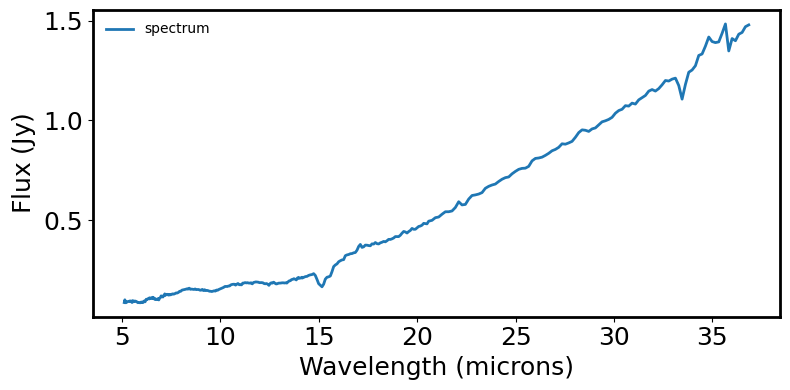

In [17]:
# Read in the spectra and plot it for initial visualization check

data = ascii.read(YSO1)
# data = ascii.read(YSO2)
# data = ascii.read(YSO3)

if data.colnames[0] == 'col1':
    data['col1'].name = 'wave_mum'
    data['col2'].name = 'cSpec_Jy'            
    data['col3'].name = 'errFl_Jy'         

wav = data['wave_mum'] * u.micron  # Wavelength: microns
fl = data['cSpec_Jy'] * u.Jy  # Fnu: Jy
efl = data['errFl_Jy'] * u.Jy  # Error flux: Jy

spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl))  # Make a 1D spectrum object
fig = plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux, label='spectrum')                
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

### Fit a generic continuum

The continuum seems to be overestimated 5 micron - 7 micron and then again 17 micron - 25 micron when fitting a generic continuum without excluding any wavelengths. This leads to misidentification of emissiona and abroption lines. Rather I fit a continuum to 5-13 micron range and another continuum for the 13-35 micron range. This gives a much better continuum subtracted spectrum. But that means that I will have to keep track of two different line lists fo absorption and emission features. It would be better if I can fit one continuum.

In [18]:
# Calculate S/N
sig2noise = np.round(snr(spec), 2)

# Fit one continuum for wavelengths greater than 13 microns excluding a couple lines
to_exclude_1 = [(5.0, 13.0)*u.micron, (14.5, 15.5) * u.micron, (17.0, 18.0) * u.micron]  # Define lines/regions to exclude
exclude_region_1 = SpectralRegion(to_exclude_1)  # Make a specutils region

# Another continuum fit for wavelengths under 13 microns excluding the silicate absorption feature
to_exclude_2 = [(7.0, 11.0)*u.micron, (13.0, 35.0)*u.micron]
exclude_region_2 = SpectralRegion(to_exclude_2)

continuum_model_1 = fit_generic_continuum(spec, exclude_regions=exclude_region_1)  # Generate the first contimiumn
continuum_model_2 = fit_generic_continuum(spec, exclude_regions=exclude_region_2)  # Generate the second contimiumn
y_continuum_1 = continuum_model_1(spec.spectral_axis)  # Put the first continiumn into 1d spectra object
y_continuum_2 = continuum_model_2(spec.spectral_axis)  # Put the second continiumn into 1d spectra object

# Generate a continuum subtracted and continuum normalised spectra. Both needed for later analysis. 
spec_norm_2 = spec / y_continuum_2
count_axis = 0
for i in spec.spectral_axis:
    if i.value < 13.0:
        count_axis = count_axis+1

# Assign to variable to make it more readable for line below
spec_contsub_1 = spec[count_axis:len(spec.spectral_axis)] - y_continuum_1[count_axis:len(spec.spectral_axis)]
spec_contsub_2 = spec[0:count_axis] - y_continuum_2[0:count_axis]


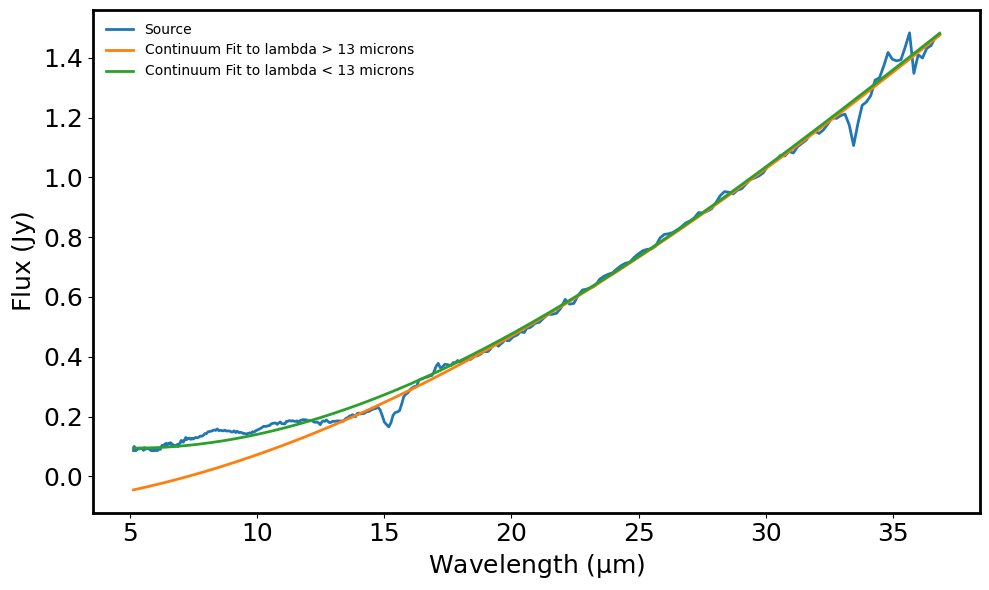

In [19]:
# Plot the continiumn and spectra
fig = plt.figure(figsize=(10, 6))
plt.plot(spec.spectral_axis, spec.flux, label='Source')  # Source spectrum 
plt.plot(spec.spectral_axis, y_continuum_1, label='Continuum Fit to lambda > 13 microns')  # Continuum (lambda > 13 microns)
plt.plot(spec.spectral_axis, y_continuum_2, label='Continuum Fit to lambda < 13 microns')  # Continuum (lambda < 13 microns)

plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

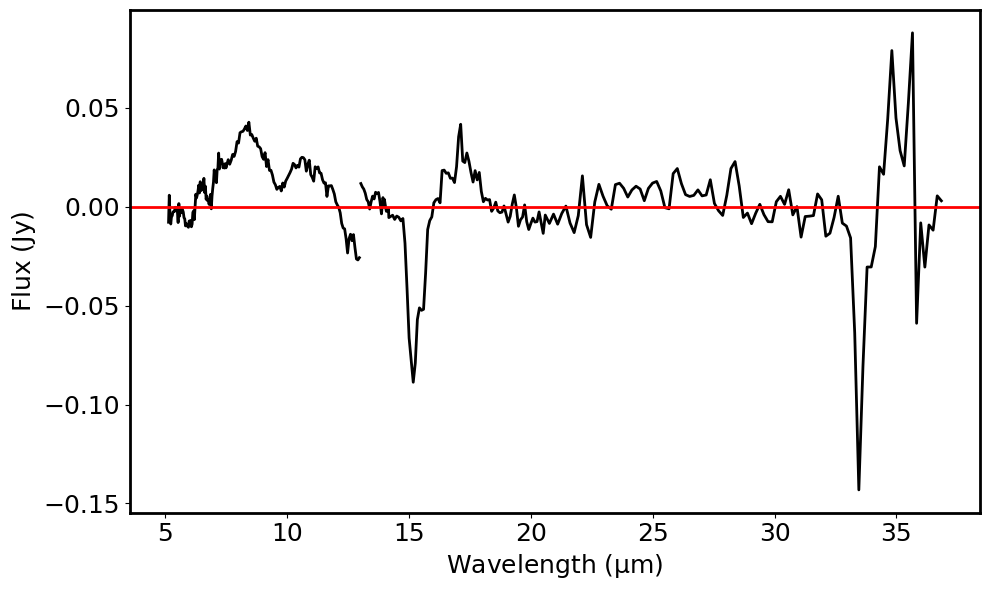

In [20]:
# Plot the contimum subtracted spectrum

fig = plt.figure(figsize=(10, 6))
plt.plot(spec_contsub_1.spectral_axis, spec_contsub_1.flux, color='black')
plt.plot(spec_contsub_2.spectral_axis, spec_contsub_2.flux, color='black')
plt.axhline(y=0.0, color='r', linestyle='-')

plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.tight_layout()
plt.show()
plt.close()

### Look For Emission and Absorption Lines

Common YSO lines include PAH emission lines, ice absorption lines, and silicate absorption lines.

It would be better to have a SNR threshold instead of a flux threshold for the `find_lines_derivative()` function.

The user has to remove the comment depending on which YSO they are checking: YSO1, YSO2, or YSO3. If it was a SNR threshold instead, then it can be a bit more automated. 

In [21]:
# Find emmision and absorption lines in the continuum-subtracted spectra.
# This will print out two emission line lists and two absorption line lists.

if sig2noise > 10:
    lines = find_lines_derivative(spec_contsub_1, flux_threshold=0.020)  # YSO 1
    # lines = find_lines_derivative(spec_contsub_1, flux_threshold=0.03)  # YSO 2
    # lines = find_lines_derivative(spec_contsub_1, flux_threshold=0.02)  # YSO 3
    if len(lines) > 0:
        emissionlines_1 = lines[lines['line_type'] == 'emission']  # Grab a list of the emission lines
        abslines_1 = lines[lines['line_type'] == 'absorption']  # Grab a list of the absorption lines
        print("Number of emission lines found:", len(emissionlines_1))
        print("Number of absorption lines found:", len(abslines_1))
    else:
        emissionlines_1 = []
        abslines_1 = []
        print("No emission lines found!") 

    lines = find_lines_derivative(spec_contsub_2, flux_threshold=0.020)  # YSO 1
    # lines = find_lines_derivative(spec_contsub_2, flux_threshold=0.03)  # YSO 2
    # lines = find_lines_derivative(spec_contsub_2, flux_threshold=0.02)  # YSO 3
    if len(lines) > 0:
        emissionlines_2 = lines[lines['line_type'] == 'emission']  # Grab a list of the emission lines
        abslines_2 = lines[lines['line_type'] == 'absorption']  # Grab a list of the absorption lines
        print("Number of emission lines found:", len(emissionlines_2))
        print("Number of absorption lines found:", len(abslines_2))
    else:
        emissionlines_2 = []
        abslines_2 = []
        print("No emission lines found!") 

Number of emission lines found: 4
Number of absorption lines found: 2
Number of emission lines found: 5
Number of absorption lines found: 1



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


In [22]:
# Extract emission lines greater than 13 microns

if emissionlines_1:
    emissionlines_1['gauss_line_center'] = 0. * u.micron
    emissionlines_1['gauss_line_amp'] = 0. * u.jansky
    emissionlines_1['gauss_line_stddev'] = 0. * u.micron
    emissionlines_1['gauss_line_FWHM'] = 0. * u.micron
    emissionlines_1['gauss_line_area'] = np.log10(1e-20) * u.W / u.m**2

    emissionlines_1['no_AltRestWav'] = 0  # Number of possible lines which could be the feature
    emissionlines_1['RestWav'] = 0.  # RestWavelength of closest lab measured line
    emissionlines_1['diff_ft_wav'] = 0.  # Diff. in initial line wav estimate and the fitted gausian
    emissionlines_1['line_suspect'] = 0  # Set == 1 if large diffrence in wavelength possition
    emissionlines_1['line'] = "                 "  # For storing the line name

    # Loop through all the found emission lines in the spectra
    for idx, emlines in enumerate(emissionlines_1):

        # Look at the region surrounding the found lines from the original smoothed spectrum
        sw_line = emissionlines_1["line_center"][idx].value-0.001
        lw_line = emissionlines_1["line_center"][idx].value+0.001     
        line_region = SpectralRegion(sw_line*u.um, lw_line*u.um)

        # Variable for the line center
        line_cnr = emissionlines_1["line_center"][idx]
        
print(emissionlines_1)

# Extract emission lines less than 13 microns

if emissionlines_2:
    emissionlines_2['gauss_line_center'] = 0. * u.micron
    emissionlines_2['gauss_line_amp'] = 0. * u.jansky
    emissionlines_2['gauss_line_stddev'] = 0. * u.micron
    emissionlines_2['gauss_line_FWHM'] = 0. * u.micron
    emissionlines_2['gauss_line_area'] = np.log10(1e-20) * u.W / u.m**2

    emissionlines_2['no_AltRestWav'] = 0  # Number of possible lines which could be the feature
    emissionlines_2['RestWav'] = 0.  # RestWavelength of closest lab measured line
    emissionlines_2['diff_ft_wav'] = 0.  # Diff. in initial line wav estimate and the fitted gausian
    emissionlines_2['line_suspect'] = 0  # Set == 1 if large diffrence in wavelength possition
    emissionlines_2['line'] = "                 "  # For storing the line name
    
    # Loop through all the found emission lines in the spectra

    for idx, emlines2 in enumerate(emissionlines_2):

        # Look at the region surrounding the found lines from the original smoothed spectrum
        sw_line = emissionlines_2["line_center"][idx].value-0.01
        lw_line = emissionlines_2["line_center"][idx].value+0.01     
        line_region = SpectralRegion(sw_line*u.um, lw_line*u.um)

        # Variable for the line center
        line_cnr = emissionlines_2["line_center"][idx]     
         
print(emissionlines_2)

line_center line_type line_center_index ... line_suspect        line      
   micron                               ...                               
----------- --------- ----------------- ... ------------ -----------------
     17.033  emission                56 ...            0                  
    17.3717  emission                60 ...            0                  
    34.8152  emission               182 ...            0                  
    35.4926  emission               186 ...            0                  
line_center line_type line_center_index ... line_suspect        line      
   micron                               ...                               
----------- --------- ----------------- ... ------------ -----------------
     7.2737  emission                71 ...            0                  
    8.18096  emission                90 ...            0                  
    10.2374  emission               124 ...            0                  
    10.6003  emission    

In [23]:
# Extract absorption lines greater than 13 microns

if abslines_1:
    abslines_1['gauss_line_center'] = 0. * u.micron
    abslines_1['gauss_line_amp'] = 0. * u.jansky
    abslines_1['gauss_line_stddev'] = 0. * u.micron
    abslines_1['gauss_line_FWHM'] = 0. * u.micron
    abslines_1['gauss_line_area'] = np.log10(1e-20) * u.W / u.m**2

    abslines_1['no_AltRestWav'] = 0  # Number of possible lines which could be the feature
    abslines_1['RestWav'] = 0.  # RestWavelength of closest lab measured line
    abslines_1['diff_ft_wav'] = 0.  # Diff. in initial line wav estimate and the fitted gausian
    abslines_1['line_suspect'] = 0  # Set == 1 if large diffrence in wavelength possition
    abslines_1['line'] = "                 "  # For storing the line name

    # Loop through all the found absorption lines in the spectra

    for idx, absorplines in enumerate(abslines_1):

        # Look at the region surrounding the found lines from the original smoothed spectrum
        sw_line = abslines_1["line_center"][idx].value-0.01
        lw_line = abslines_1["line_center"][idx].value+0.01     
        line_region = SpectralRegion(sw_line*u.um, lw_line*u.um)

        # Variable for the line center
        line_cnr_abs = abslines_1["line_center"][idx]
        
print(abslines_1)

# Extract absorption lines less than 13 microns

if abslines_2:
    abslines_2['gauss_line_center'] = 0. * u.micron
    abslines_2['gauss_line_amp'] = 0. * u.jansky
    abslines_2['gauss_line_stddev'] = 0. * u.micron
    abslines_2['gauss_line_FWHM'] = 0. * u.micron
    abslines_2['gauss_line_area'] = np.log10(1e-20) * u.W / u.m**2

    abslines_2['no_AltRestWav'] = 0  # Number of possible lines which could be the feature
    abslines_2['RestWav'] = 0.  # RestWavelength of closest lab measured line
    abslines_2['diff_ft_wav'] = 0.  # Diff. in initial line wav estimate and the fitted gausian
    abslines_2['line_suspect'] = 0  # Set == 1 if large diffrence in wavelength possition
    abslines_2['line'] = "                 "  # For storing the line name
    
    # Loop through all the found absorption lines in the spectra

    for idx, absorplines2 in enumerate(abslines_2):

        # Look at the region surrounding the found lines from the original smoothed spectrum
        sw_line = abslines_2["line_center"][idx].value - 0.01
        lw_line = abslines_2["line_center"][idx].value + 0.01     
        line_region = SpectralRegion(sw_line*u.um, lw_line*u.um)

        # Variable for the line center
        line_cnr_abs = abslines_2["line_center"][idx]

print(abslines_2)

line_center line_type  line_center_index ... line_suspect        line      
   micron                                ...                               
----------- ---------- ----------------- ... ------------ -----------------
    15.1701 absorption                34 ...            0                  
    33.4604 absorption               174 ...            0                  
line_center line_type  line_center_index ... line_suspect        line      
   micron                                ...                               
----------- ---------- ----------------- ... ------------ -----------------
    12.7777 absorption               166 ...            0                  


### Identify emission and absorption lines

PAH emission feature: 6.2 micron, 7.7 micron, 8.6 micron, 11.3 micron, 12.0 micron, 12.7 micron, 14.2 micron, 16.2 micron

Silicate absoprtion feature: 10.0 micron, 18.0 micron, 23.0 micron

CO2 ice absorption feature: 15.2 micron

Other ice features: CO (4.67 micron), H2O + HCOOH (6 micron),  CH3OH (6.89 micron), CH4 (7.7 micron)

If none of these 8 emission lines and 8 absorption lines exist, then this is not a YSO

In [24]:
# First Look for pah emission features

pah_emission = [6.2, 7.7, 8.6, 11.3, 12.0, 12.7, 14.2, 16.2] * u.micron  # list or known YSO pah emission lines
len_pah_list = len(pah_emission)

pah_emission_detected = []  # empty list to store detected lines
line_cnr_list_1 = emissionlines_1["line_center"]  # list of emission lines extracted from first spectrum
len_line_list = len(line_cnr_list_1)
line_cnr_list_2 = emissionlines_2["line_center"]  # list of emission lines extracted from second spectrum
len_line_list2 = len(line_cnr_list_2)

count_pah1 = 0  # counting how many pah emission lines exist in first spectrum
for i in range(0, len_pah_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.15 < pah_emission.value[i] < line_cnr_list_1[j].value + 0.15:
            count_pah1 += 1
count_pah2 = 0  # counting how many pah emission lines exist in second spectrum
for i in range(0, len_pah_list):
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.15 < pah_emission.value[i] < line_cnr_list_2[j].value + 0.15:
            count_pah2 += 1

pah_emission_detected = []  # empty list to store detected lines
count_pah = 0  # restart count
for i in range(0, len_pah_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.15 < pah_emission.value[i] < line_cnr_list_1[j].value + 0.15:
            pah_emission_detected.append(line_cnr_list_1[j])
            count_pah += 1
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.15 < pah_emission.value[i] < line_cnr_list_2[j].value + 0.15:
            pah_emission_detected.append(line_cnr_list_2[j])
            count_pah += 1

print(f"{count_pah} PAH emission lines detected in spectrum")
if count_pah > 0:
    print(pah_emission_detected)

0 PAH emission lines detected in spectrum


In [25]:
# Look for Silicate absorption features

sil_absorption = [10.0, 18.0, 23.0] * u.micron  # list or known YSO silicate absorption lines
len_sil_list = len(sil_absorption)

sil_absorption_detected = []  # empty array to store detected lines
line_cnr_list_1 = abslines_1["line_center"]  # list of absorption lines extracted from first spectrum
len_line_list = len(line_cnr_list_1)
line_cnr_list_2 = abslines_2["line_center"]  # list of absorption lines extracted from second spectrum
len_line_list2 = len(line_cnr_list_2)

count_sil1 = 0  # counting how many silicate absorption lines exist in first spectrum
for i in range(0, len_sil_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.3 < sil_absorption.value[i] < line_cnr_list_1[j].value + 0.3:  # absorption features are wider than emission features therefore +/-0.2
            count_sil1 += 1
count_sil2 = 0  # counting how many silicate absorption lines exist in second spectrum
for i in range(0, len_sil_list):
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.3 < sil_absorption.value[i] < line_cnr_list_2[j].value + 0.3:  # absorption features are wider than emission features therefore +/-0.2
            count_sil2 += 1
            
sil_absorption_detected = []  # empty array to store detected lines
count_sil = 0  # restart count
for i in range(0, len_sil_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.3 < sil_absorption.value[i] < line_cnr_list_1[j].value + 0.3:
            sil_absorption_detected.append(sil_absorption[i])
            count_sil += 1
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.3 < sil_absorption.value[i] < line_cnr_list_2[j].value + 0.3:
            sil_absorption_detected.append(sil_absorption[i])
            count_sil += 1
            
# Remove multiple detections of same line
drop_dups_sil = list(set(sil_absorption_detected))
print(f"{len(drop_dups_sil)} silicate absorption lines detected in spectrum")

0 silicate absorption lines detected in spectrum


In [26]:
# Look for ice absorption features

ice_absorption = [4.67, 6.0, 6.9, 7.7, 15.2] * u.micron  # list or known YSO ice absorption lines
len_ice_list = len(ice_absorption)

ice_absorption_detected = []  # empty array to store detected lines
line_cnr_list_1 = abslines_1["line_center"]  # list of absorption lines extracted from first spectrum
len_line_list = len(line_cnr_list_1)
line_cnr_list_2 = abslines_2["line_center"]  # list of absorption lines extracted from second spectrum
len_line_list2 = len(line_cnr_list_2)

count_ice1 = 0  # counting how many ice absorption lines exist in first spectrum
for i in range(0, len_ice_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.2 < ice_absorption.value[i] < line_cnr_list_1[j].value + 0.2:   
            count_ice1 += 1
count_ice2 = 0  # counting how many ice absorption lines exist in second spectrum
for i in range(0, len_ice_list):
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.2 < ice_absorption.value[i] < line_cnr_list_2[j].value + 0.2: 
            count_ice2 += 1
            
ice_absorption_detected = []  # empty array to store detected lines
count_ice = 0  # restart count
for i in range(0, len_ice_list):
    for j in range(0, len_line_list):
        if line_cnr_list_1[j].value - 0.2 < ice_absorption.value[i] < line_cnr_list_1[j].value + 0.2:
            ice_absorption_detected.append(ice_absorption[i])
            count_ice += 1
    for j in range(0, len_line_list2):
        if line_cnr_list_2[j].value - 0.2 < ice_absorption.value[i] < line_cnr_list_2[j].value + 0.2:
            ice_absorption_detected.append(ice_absorption[i])
            count_ice += 1
             
# Remove multiple detections of same line
drop_dups_ice = list(set(ice_absorption_detected))
print(f"{len(drop_dups_ice)} ice absorption lines detected in spectrum")

1 ice absorption lines detected in spectrum


### Classify the YSO according to what lines are detected

If more than one classification pops up, then the user needs to take a closer look and the YSO can be inbetween. For example if you get "This is a Class 2 YSO" and "This is a class 3 YSO", then the protostar can be inbetween these two phases in its evolution and be a Class 2/3 YSO.

In [27]:
# If no PAH, silicate, and ice lines found then print this is not a YSO
if not pah_emission_detected and not sil_absorption_detected and not ice_absorption_detected:
    print("This is not a YSO.")
    
else:
    # Else find out if YSO 1 (youngest, most embedded YSO with CO2 absorption feature at 15.2 microns)
    if drop_dups_ice and not drop_dups_sil:
        for i in range(0, count_ice):
            if ice_absorption_detected[i].value < 15.4 and ice_absorption_detected[i].value > 15.0:
                    print("This is a Class 1 YSO.")
                    
    # Else find out if YSO 2 (more evolved YSO with other ice absoprtion and silicate absorption features)
    if drop_dups_sil:
        print("This is a Class 2 YSO.")  
    elif count_pah == 0 and drop_dups_ice:
        for i in range(0, count_ice):
            if ((ice_absorption_detected[i].value < 4.87 and ice_absorption_detected[i].value > 4.47)
                or (ice_absorption_detected[i].value < 5.8 and ice_absorption_detected[i].value > 6.2)
                or (ice_absorption_detected[i].value < 6.69 and ice_absorption_detected[i].value > 7.09)
                or (ice_absorption_detected[i].value < 7.5 and ice_absorption_detected[i].value > 7.7)):
                print("This is a Class 2 YSO.")
                
    # Else if PAH emission features then YSO 3
    if ((count_pah > 0 and not drop_dups_ice)
        or (count_pah > 0 and drop_dups_sil)):
        print("This is a Class 3 YSO.")

This is a Class 1 YSO.


### Plot the spectra and label the emission and absorption features

ice absorption lines detected:  [<Quantity 15.2 micron>]


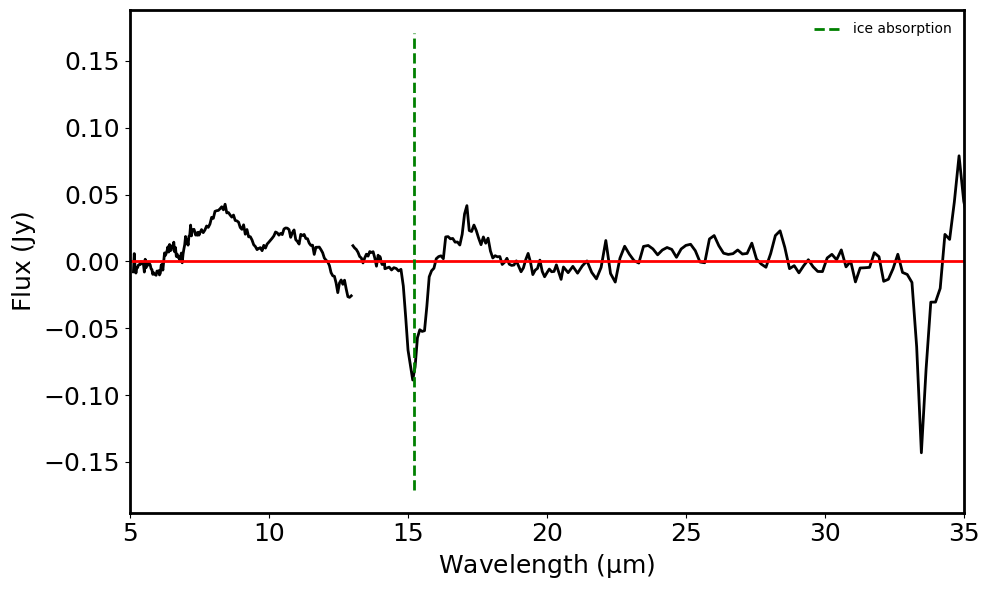

In [28]:
fig = plt.figure(figsize=(10, 6))
plt.plot(spec_contsub_1.spectral_axis, spec_contsub_1.flux, color='black')
plt.plot(spec_contsub_2.spectral_axis, spec_contsub_2.flux, color='black')

plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.axhline(y=0.0, color='r', linestyle='-')

max_emission_plot_y = np.max(spec_contsub_2.flux.value) * 4

if len(pah_emission_detected) > 0:
    pah_vals = [v.value for v in pah_emission_detected]
    plt.vlines(pah_vals, -max_emission_plot_y, max_emission_plot_y,
               color='r', ls='--', label='PAH emission')
    print("PAH emission lines detected: ", pah_emission_detected)

if len(sil_absorption_detected) > 0:
    sil_vals = [v.value for v in sil_absorption_detected]
    plt.vlines(sil_vals, -max_emission_plot_y, max_emission_plot_y,
               color='b', ls='--', label='silicate absorption')
    print("silicate absorption lines detected: ", sil_absorption_detected)
    
if len(ice_absorption_detected) > 0:
    ice_vals = [v.value for v in ice_absorption_detected]
    plt.vlines(ice_vals, -max_emission_plot_y, max_emission_plot_y,
               color='g', ls='--', label='ice absorption')
    print("ice absorption lines detected: ", ice_absorption_detected)

plt.xlim(5, 35)
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()